# Understanding Lucas-kanade Algorithms

## Optical Flow Constraint

The brightness constancy constraint equation can be written as follows:

$$ I(x, y, t) = I(x+u, y+v, t+1) $$

In this equation, $I(x, y, t)$ represents the pixel intensity at time $t $ at location $(x, y) $. The Brightness Constancy Assumption states that the intensity at $t+1 $ at location $I(x+u, y+v) $ is going to be the same as in the frame $t$. Here, $u$ and $v$ are displacements for wich the point has moved in $x$ and $y$ direction.

This can also be rewritten as:

$$ 0 = I(x+u, y+v, t+1) – I(x, y, t) $$


**Small Motion:** When a pixel moves between two consecutive frames we assume that a movement is relatively small. We can then use the Taylor expansion in order to approximate this equation:

$$ 0 \approx I(x, y, t+1)+I_{x} u+I_{y} v-I(x, y, t) $$

Here, we are substituting the value $I(x+u, y+v, t+1)$ with the Taylor expansion. So, we have the $I(x,y,t+1)$ plus the derivative part $I_{x}u + I_{y}v$. Note that $I_{x}u$ is the derivative in the $x$-direction, and $I_{y}v$ is the derivative in the $y$-direction.

In addition, $I_{x} = \frac{\partial I}{x}$ and $I_{y} = \frac{\partial I}{y}$ for both $t$ and $t+1$. Here, we are going to assume that the things are changing slowly, so the derivative at a particular point is going to be the same both at $t$ and $t+1$.

$$ 0 \approx [I(x,y,t+1) – I(x, y, t)]+ I_{x}u + I_{y}v $$

Now, when we rearrange equation terms:

$$ 0 \approx I_{t} + I_{x}u + I_{y}v $$

This $I_{t}$, is the difference between $I(x,y,t+1) – I(x, y, t)$. So $I_{t}$ is called the temporal derivative. In addition, $I_{x}$ is the derivative of $I$ in the $x$-direction and $I_{y}$ is the derivative of $I$ in the $y$-direction. Next, $I_{t}$ is the derivative of $I$ with respect to time. Our video is a function $I(x,y,t)$, so a derivative can be taken with respect to $x$, $y$, and $t$.

$$ 0 \approx I_{t} + \bigtriangledown I \cdot [u, v] $$

Here $ \bigtriangledown I \cdot [u, v] $ is the gradient of the image, dotted with the vector $[u, v]$. We talked about Image Gradient before and you can check it out.

Finally, the brightness constancy constraint equation can be written as:

$$ I_{x}u + I_{y}v + I_{t} = 0 $$

This is an equation with two unknowns and as such cannot be solved. This is known as the aperture problem of optical flow algorithms. To find the optical flow another set of equations is needed to impose an additional constraint.

$$ I_{x}u + I_{y}v = – I_{t} $$

Note that this can be written as a single vector equation:

$$\vec{\bigtriangledown}I \cdot \vec{u} = -I_{t}$$

where:

$$ \vec{\bigtriangledown}I = \begin{bmatrix}
I_{x}\\
I_{y}
\end{bmatrix}$$, and $$ \vec{u} = \begin{bmatrix}
u\\
v
\end{bmatrix}$$

## Gradient Component of Flow

In the last paragraph we get to this equation, which is the brightness constancy constraint equation:

$$ I_{x}u+I_{y}v+I_{t}= 0 $$

A question is how many unknowns and how many equations per pixel do we have? Here, we have two unknowns $u$ and $v$ but only one equation per pixel.

The component of $\left ( u,v \right )$ that is in the direction of the gradient is something we can measure. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import os
import seaborn as sns
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


import scipy as sp
from scipy import signal

In [2]:
def emd(x, nIMF = 3, stoplim = .0001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs


def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))


def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [3]:
def translate(value, leftMin=0, leftMax=255, rightMin=10, rightMax=40):
    
    '''
    Input: Input Pixel Value, Min of Pixel, Max Of Pixel, Min of Temp, Max of Temp
    Return: Temp value corresponsing to input pixel value
    '''
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [4]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [10]:
# convert function to vectorised form
translate_vec = np.vectorize(translate)

# read the txt file where the files to read are mentioned
#filenames = ['09282022_7.MP4','09282022_8.MP4','09282022_9.MP4','09282022_10.MP4']

# participant 1
#filenames = ['20221007T152308.MP4','20221007T152616-clip1.mp4','20221007T152616-clip2.mp4','20221007T152616-clip3.mp4',
#            '20221007T152940-clip1.mp4','20221007T152940-clip2.mp4','20221007T152940-clip3.mp4','20221007T153242-clip1.mp4',
#            '20221007T153242-clip2.mp4','20221007T153242-clip3.mp4','20221007T153558.mp4']

# participant 1
# unsplitted
#filenames = ['20221007T152308.MP4','20221007T152616.mp4','20221007T152940.mp4','20221007T153242.mp4','20221007T153558.mp4']

# participant 2
#filenames = ['20221007T155451.MP4','20221007T155725-clip1.mp4','20221007T155725-clip2.mp4','20221007T155725-clip3.mp4',
#            '20221007T160047-clip1.mp4','20221007T160047-clip2.mp4','20221007T160047-clip3.mp4','20221007T160405-clip1.mp4',
#            '20221007T160405-clip2.mp4','20221007T160405-clip3.mp4','20221007T160717.mp4']

# particiapant 2
# unsplitted
filenames = ['20221007T155451.mp4','20221007T155725.mp4','20221007T160047.mp4','20221007T160405.mp4','20221007T160717.mp4']


#path_to_file = "../../../Documents/thermal-project-data/cycling/split/"
path_to_file = "../../../Documents/thermal-project-data/cycling/"


def click_event(event, x, y, flags, params):
    global old_points, first_point;
    if event == cv2.EVENT_LBUTTONDOWN:
        old_points = np.array([[x,y,]], dtype=np.float32)
        first_point = old_points
        
# lucas kanade params
lk_param = dict(winSize=(50,50), maxLevel=100, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))
    

# keep a count of frames in total across all the videos.
frameCount = 1

# list to store all the ROI's sum of pixels for each frame of each video
rrSignal = []

# list to store temperature value of ROI in each frame
frame_temp_list = []

for file in filenames:
    full_path = os.path.join(path_to_file+file)
    print(full_path)
    cap = cv2.VideoCapture(full_path)
    
    # get the frame rate
    fps = cap.get(cv2.CAP_PROP_FPS)

    # read the first frame of the video
    correct,frame = cap.read()
    
    if not correct:
        break;

    # convert the first frame to grayscale
    old_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    # show the first frame. imshow requires param to be in BGR format unlike Matplotlib's RGB
    cv2.imshow('image', frame)
    #b,g,r = cv2.split(frame)
    #frame = cv2.merge((r,g,b))

    # hook the function to be called in case of mouse click
    cv2.setMouseCallback('image', click_event)

    # wait infinitely until a key is pressed.
    cv2.waitKey(0)
    firstWhileLoopRun=True;
    
    while True:
        sumPixels = 0;

        # read the second frame
        correct, frame = cap.read()
        if not correct:
            break;
        frameCount+=1

        # get the size of the frame
        height, width, channel = frame.shape
        
        # create a all-zeros mask, we are doing this to get all the pixels covered by the circle
        mask = np.zeros((height, width), np.uint8)

        # convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # get the new points for optical flow
        new_points, status, error = cv2.calcOpticalFlowPyrLK(old_gray, gray_frame, old_points, None, **lk_param)
        # update the old frame to the current frame
        old_gray = gray_frame.copy()
        # update the old points to new points
        old_points = new_points

        # make arrangements to plot the points
        x,y = new_points.ravel()
        x_i, y_i = first_point.ravel()

        circleRadius = 5
        
        # draw the point where the initial click was made
        if firstWhileLoopRun:
            cv2.circle(frame, (int(x_i),int(y_i)),circleRadius,(0,0,255),-1)
            firstWhileLoopRun=False

        
        # draw the moving point as per optical flows
        cv2.circle(frame, (int(x),int(y)),circleRadius,(255,0,0),-1)

        # create the circle with new point over the mask as well
        circle_mask = cv2.circle(mask, (int(x), int(y)),circleRadius,(255,0,0),-1)
        masked_data = cv2.bitwise_and(gray_frame,gray_frame,mask=circle_mask)

        # code to get all pixel location inside the ROI in the optical flow
        tom, thres = cv2.threshold(mask, 1,255, cv2.THRESH_BINARY)
        contours = cv2.findContours(thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x,y,w,h = cv2.boundingRect(contours[0][0])
        crop = masked_data[y:y+h,x:x+w]
        
        #at this point, change all values of pixel to temperature value.
        # store temperature values in a list
        #frame_temp = translate_vec(crop)
        frame_temp = crop
        frame_temp_list.append(np.sum(frame_temp[:,:])/(frame_temp.shape[0]*frame_temp.shape[1]))
        
        # now that we have the pixels corresponding to the ROI, lets sum of all pixels.
        sumPixels = np.sum(crop[:,:])
        # for each frame, store the sumPixel in an array. This array is the signal for RR
        rrSignal.append(sumPixels)


        cv2.imshow("Frame", frame)
        #key = cv2.waitKey(int((1/fps)*1000))
        
        # in case we need a faster playback so that we have the temperature data quickly then uncomment the
        # next line and comment the line above
        
        key = cv2.waitKey(1)
        if key == 27 or key == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
rrSignal_t = [f/fps for f in range(1,frameCount)]   

../../../Documents/thermal-project-data/cycling/20221007T155451.mp4
../../../Documents/thermal-project-data/cycling/20221007T155725.mp4
../../../Documents/thermal-project-data/cycling/20221007T160047.mp4
../../../Documents/thermal-project-data/cycling/20221007T160405.mp4
../../../Documents/thermal-project-data/cycling/20221007T160717.mp4


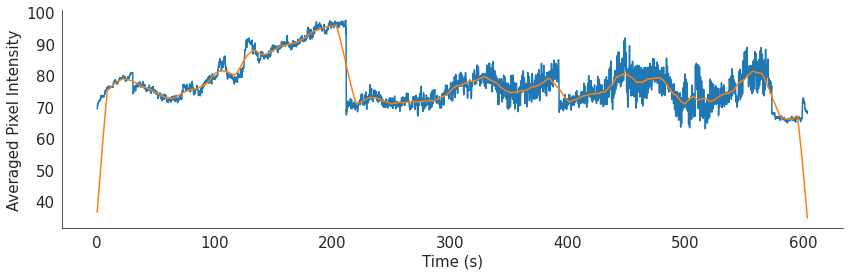

In [8]:
# Participant 2

size = 150
window = sp.signal.gaussian(M=size, std=100)
window /= window.sum()
filteredA = np.convolve(np.array(frame_temp_list), window, mode='same')


# at the tip of the nose
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.plot(rrSignal_t,frame_temp_list)
ax.plot(rrSignal_t,filteredA)

#ax.set_ylim((140,170))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Averaged Pixel Intensity")
#plt.axvline(x = 30, color = 'g', label = '30s')
#plt.axvline(x = 120, color = 'b', label = '120s')

#ax.legend(['Temperature', 'Recorded Post Staircase Climb', 'Recorded Post 1 Hour Rest'])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
#ax.set_xlim((50,100))

In [62]:
import plotly.graph_objects as go

In [66]:
# Use plotly plots 
fig = go.Figure(data=go.Scatter(x=rrSignal_t, y=filteredA))
fig.show()

In [73]:
# Calculates average of pixel given the time stamps in seconds.
fromT = 570
toT = 571
temp = [rrSignal_t.index(i) for i in rrSignal_t if i>=fromT and i <toT]
print("Median = {:.2f}".format(np.median(filteredA[temp])))
print("Mean = {:.2f}".format(np.mean(filteredA[temp])))

Median = 151.97
Mean = 151.97


/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_67937/740068921.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.ylabel('IMF '+np.str(i+1))
/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_67937/740068921.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.ylabel('IMF '+np.str(i+1))
/var/folders/_3/x_hy8vf90v93s9rdb_r5pj14

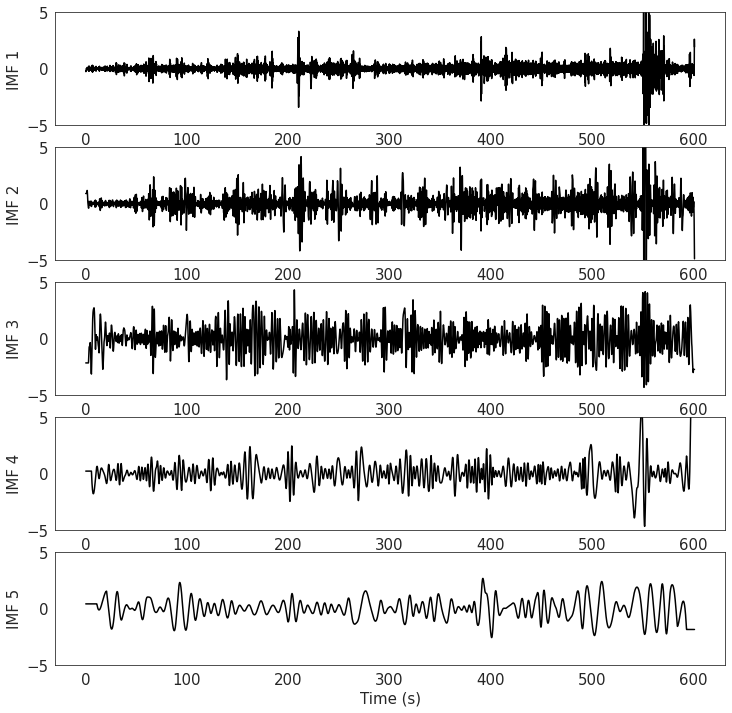

In [131]:
# participant 2: EMD
input_signal = np.array(frame_temp_list)
imfs = emd(input_signal, nIMF = 5)
plt.figure(figsize=(12,12))
for i in range(len(imfs)):
    plt.subplot(len(imfs),1,i+1)
    plt.plot(rrSignal_t,input_signal,color='0.6')
    plt.plot(rrSignal_t,imfs[i],'k')
    plt.ylim([-5,5])
    plt.ylabel('IMF '+np.str(i+1))
    if i == len(imfs)-1:
        plt.xlabel('Time (s)')

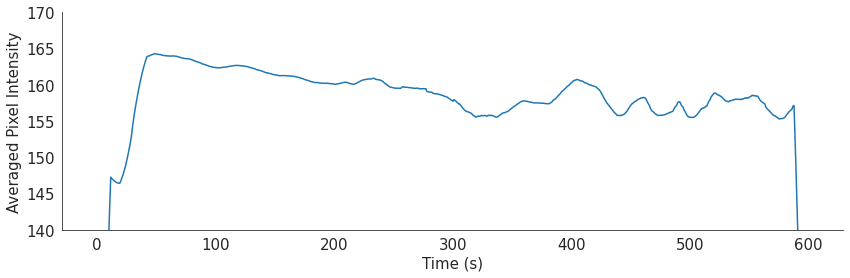

In [149]:
# Participant 1

size = 50
window = sp.signal.gaussian(M=size, std=100)
window /= window.sum()
filteredA = np.convolve(np.array(frame_temp_list), window, mode='same')


# at the tip of the nose
fig, ax = plt.subplots(1,1, figsize=(14,4))
#ax.plot(rrSignal_t,frame_temp_list)
ax.plot(rrSignal_t,filteredA)

ax.set_ylim((140,170))
#ax.set_xlim((180,240))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Averaged Pixel Intensity")
#plt.axvline(x = 30, color = 'g', label = '30s')
#plt.axvline(x = 120, color = 'b', label = '120s')

#ax.legend(['Temperature', 'Recorded Post Staircase Climb', 'Recorded Post 1 Hour Rest'])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
#ax.set_xlim((50,100))

/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_67937/1020243288.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.ylabel('IMF '+np.str(i+1))
/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_67937/1020243288.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.ylabel('IMF '+np.str(i+1))
/var/folders/_3/x_hy8vf90v93s9rdb_r5pj

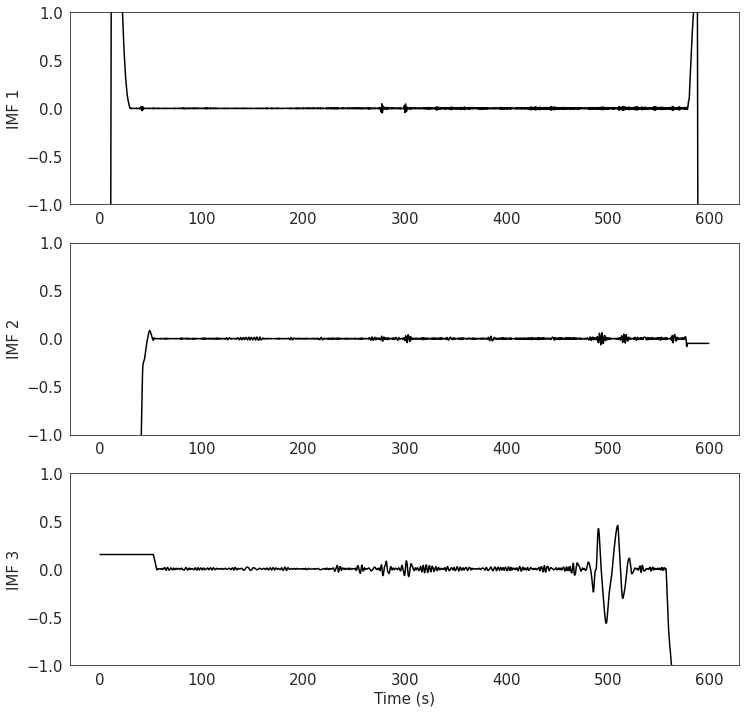

In [151]:
# participant 1: EMD
input_signal = filteredA
imfs = emd(input_signal, nIMF = 3)
plt.figure(figsize=(12,12))
for i in range(len(imfs)):
    plt.subplot(len(imfs),1,i+1)
    plt.plot(rrSignal_t,input_signal,color='0.6')
    plt.plot(rrSignal_t,imfs[i],'k')
    plt.ylim([-1,1])
    plt.ylabel('IMF '+np.str(i+1))
    if i == len(imfs)-1:
        plt.xlabel('Time (s)')

In [ ]:
# lets assume that the FPS is 9
# now we print the average for every 10 seconds of data i.e. average of 30*9 data points.

In [16]:
avgTemp30s = []
for i in range(0,round(rrSignal_t[-1]),30):
    dataInterest = filteredA[int(i*9): int((i+30)*9)]
    avgTemp30s.append(dataInterest.sum()/len(dataInterest))

/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_17699/2063740844.py:4: RuntimeWarning: invalid value encountered in double_scalars
  avgTemp30s.append(dataInterest.sum()/len(dataInterest))


In [17]:
avgTemp30s

[20.851823306028223,
 18.685686604747517,
 17.139506883407048,
 17.17047154110459,
 18.179596106613253,
 17.39116058852109,
 17.793942684300724,
 nan]

In [18]:
tem = [20.9, 18.7, 17.1, 17.2, 18.2, 17.4, 17.8]
cal = [1.4, 12.3, 13.8, 7.9, 8.9, 10.4, 9.6]

In [24]:
print(18.7-17.1)
print(13.8-12.3)

1.5999999999999979
5.9


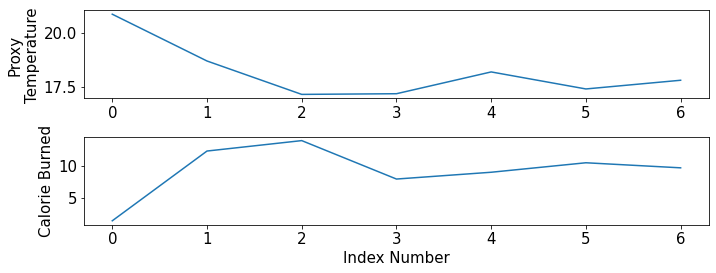

In [21]:
fig, ax = plt.subplots(2,1, figsize = (10,4))
ax[0].plot(avgTemp30s)
ax[0].set_ylabel("Proxy\nTemperature")
ax[1].plot(cal)
ax[1].set_ylabel("Calorie Burned")
ax[1].set_xlabel('Index Number')
fig.tight_layout()

Text(0, 0.5, 'BrPM')

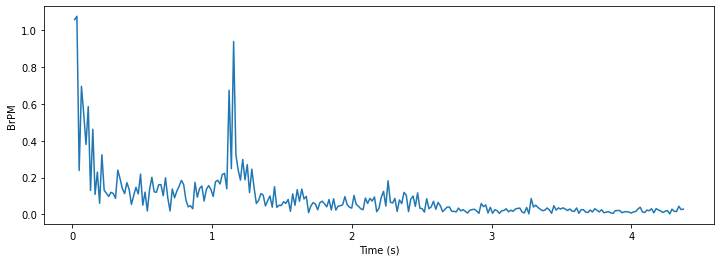

In [126]:
F,A = compute_fft(sumofPixel[540:540+540], fps, n = None, scale_amplitudes = True)
highestFreq = F[np.argmax(A[1:])+1]

fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(F[1:],A[1:])
ax.set_xlabel('Time (s)')
ax.set_ylabel('BrPM')



In [124]:
9*60

540